# Boosting Methods for Steering Classification

This notebook trains and evaluates boosting methods:
- **AdaBoost**: Adaptive Boosting with weighted samples
- **Gradient Boosting (MART)**: Fits trees to pseudo-residuals

**Key Concepts:**
- Sequential fitting: later models focus on previous mistakes
- Combines many weak learners (shallow trees) into strong learner
- Forward stagewise additive modeling


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

from utils import (
    load_data, preprocess_data, evaluate_model, 
    save_results, print_class_distribution, CLASSES, RANDOM_STATE
)

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load and Preprocess Data


In [2]:
# Load data
data = load_data()

X_raw, y_raw = data['raw']
X_eng, y_eng, feature_names = data['engineered']

print("Preprocessing RAW data with PCA:")
raw_processed = preprocess_data(
    X_raw, y_raw, 
    test_size=0.2, 
    apply_pca_reduction=True, 
    pca_variance=0.95,
    scale=False
)

print("\nPreprocessing ENGINEERED data:")
eng_processed = preprocess_data(
    X_eng, y_eng, 
    test_size=0.2, 
    apply_pca_reduction=False,
    scale=False
)

print("\nTraining set class distribution:")
print_class_distribution(raw_processed['y_train'], raw_processed['label_encoder'])


Loaded 9900 raw images
  Shape: (9900, 4096)
  Class distribution: {np.str_('forward'): np.int64(7343), np.str_('left'): np.int64(1620), np.str_('right'): np.int64(937)}
Loaded 9900 samples with 38 engineered features
  Class distribution: {'forward': np.int64(7343), 'left': np.int64(1620), 'right': np.int64(937)}
Preprocessing RAW data with PCA:
Train/Test split: 7920/1980 samples
PCA: 4096 features -> 40 components
  Variance retained: 95.02%

Preprocessing ENGINEERED data:
Train/Test split: 7920/1980 samples

Training set class distribution:
Class Distribution:
  forward: 5874 (74.2%)
  left: 1296 (16.4%)
  right: 750 (9.5%)


## 2. AdaBoost

Adaptive Boosting: sequentially fits weak learners, reweighting samples based on errors.


Training AdaBoost on RAW (PCA) features...

Model: AdaBoost | Features: raw
Accuracy:          0.8258
Balanced Accuracy: 0.7079
Macro F1:          0.7312
Weighted F1:       0.8229
Macro Precision:   0.7617
Macro Recall:      0.7079
ROC-AUC (macro):   0.8520

Per-class metrics:
  forward   : F1=0.8847, Precision=0.8693, Recall=0.9006
  left      : F1=0.6205, Precision=0.6334, Recall=0.6080
  right     : F1=0.6886, Precision=0.7823, Recall=0.6150

Classification Report:
              precision    recall  f1-score   support

     forward       0.87      0.90      0.88      1469
        left       0.63      0.61      0.62       324
       right       0.78      0.61      0.69       187

    accuracy                           0.83      1980
   macro avg       0.76      0.71      0.73      1980
weighted avg       0.82      0.83      0.82      1980



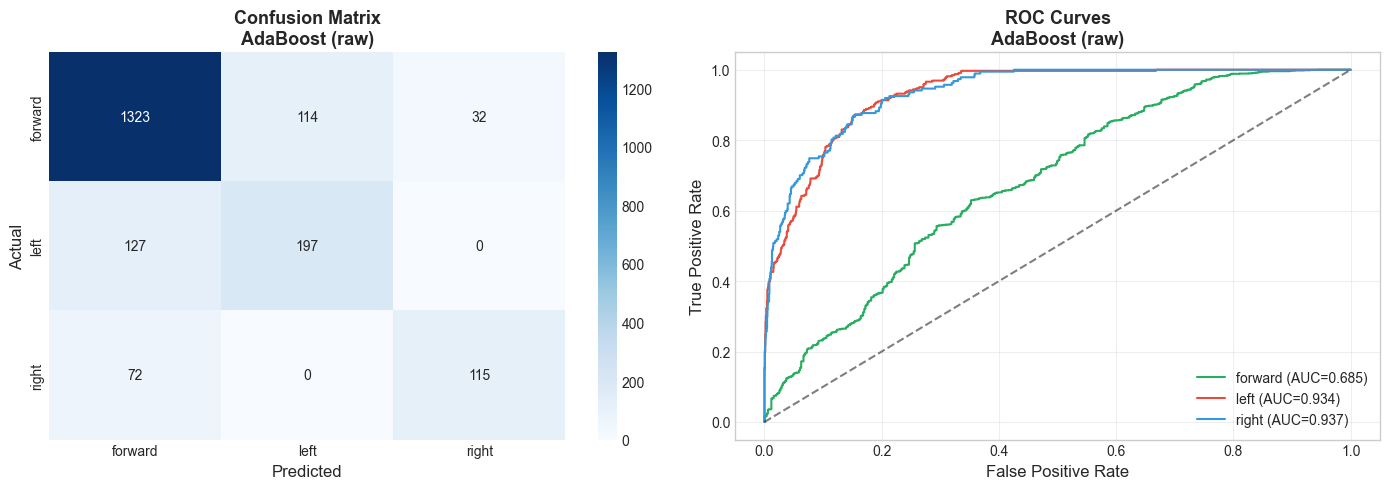

In [3]:
# AdaBoost on RAW features
print("Training AdaBoost on RAW (PCA) features...")

ada_raw = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # Stumps
    n_estimators=100,
    learning_rate=1.0,
    algorithm='SAMME',
    random_state=RANDOM_STATE
)

ada_raw.fit(raw_processed['X_train'], raw_processed['y_train'])

results_ada_raw = evaluate_model(
    ada_raw,
    raw_processed['X_test'],
    raw_processed['y_test'],
    model_name='AdaBoost',
    feature_type='raw',
    label_encoder=raw_processed['label_encoder']
)


Training AdaBoost on ENGINEERED features...

Model: AdaBoost | Features: engineered
Accuracy:          0.6015
Balanced Accuracy: 0.7210
Macro F1:          0.5620
Weighted F1:       0.6327
Macro Precision:   0.5569
Macro Recall:      0.7210
ROC-AUC (macro):   0.8481

Per-class metrics:
  forward   : F1=0.6650, Precision=0.8837, Recall=0.5330
  left      : F1=0.6201, Precision=0.5270, Recall=0.7531
  right     : F1=0.4010, Precision=0.2599, Recall=0.8770

Classification Report:
              precision    recall  f1-score   support

     forward       0.88      0.53      0.66      1469
        left       0.53      0.75      0.62       324
       right       0.26      0.88      0.40       187

    accuracy                           0.60      1980
   macro avg       0.56      0.72      0.56      1980
weighted avg       0.77      0.60      0.63      1980



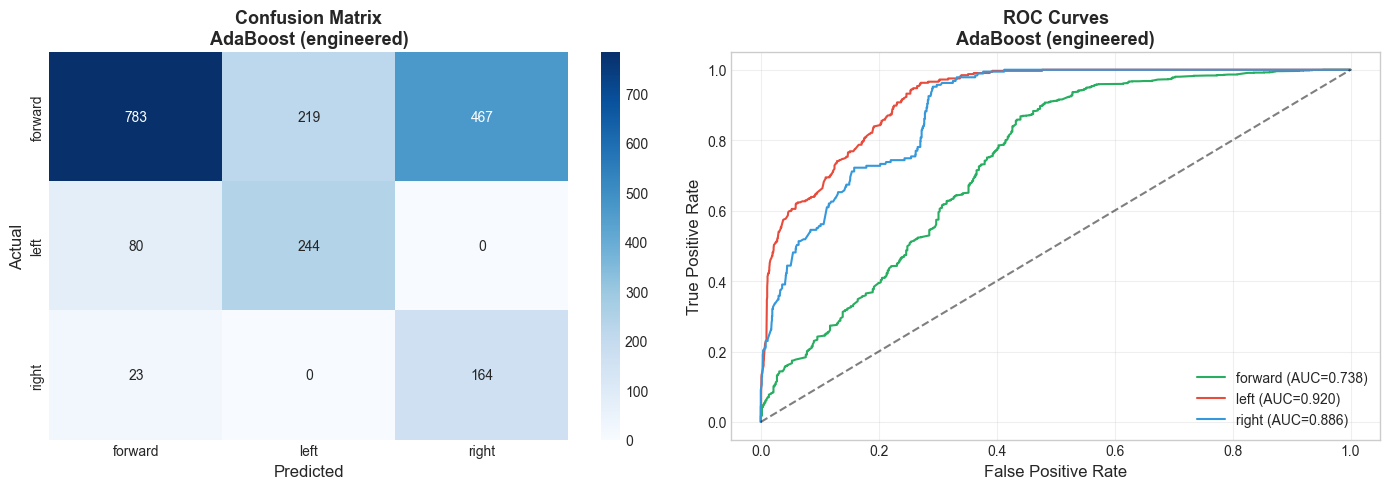

In [4]:
# AdaBoost on ENGINEERED features
print("Training AdaBoost on ENGINEERED features...")

ada_eng = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    algorithm='SAMME',
    random_state=RANDOM_STATE
)

ada_eng.fit(eng_processed['X_train'], eng_processed['y_train'])

results_ada_eng = evaluate_model(
    ada_eng,
    eng_processed['X_test'],
    eng_processed['y_test'],
    model_name='AdaBoost',
    feature_type='engineered',
    label_encoder=eng_processed['label_encoder']
)


## 3. Gradient Boosting (MART)

Fits trees sequentially to pseudo-residuals (negative gradients of loss function).


Training Gradient Boosting on RAW (PCA) features...

Model: Gradient Boosting | Features: raw
Accuracy:          0.9182
Balanced Accuracy: 0.8350
Macro F1:          0.8706
Weighted F1:       0.9152
Macro Precision:   0.9171
Macro Recall:      0.8350
ROC-AUC (macro):   0.9763

Per-class metrics:
  forward   : F1=0.9465, Precision=0.9186, Recall=0.9762
  left      : F1=0.8042, Precision=0.9170, Recall=0.7160
  right     : F1=0.8612, Precision=0.9157, Recall=0.8128

Classification Report:
              precision    recall  f1-score   support

     forward       0.92      0.98      0.95      1469
        left       0.92      0.72      0.80       324
       right       0.92      0.81      0.86       187

    accuracy                           0.92      1980
   macro avg       0.92      0.84      0.87      1980
weighted avg       0.92      0.92      0.92      1980



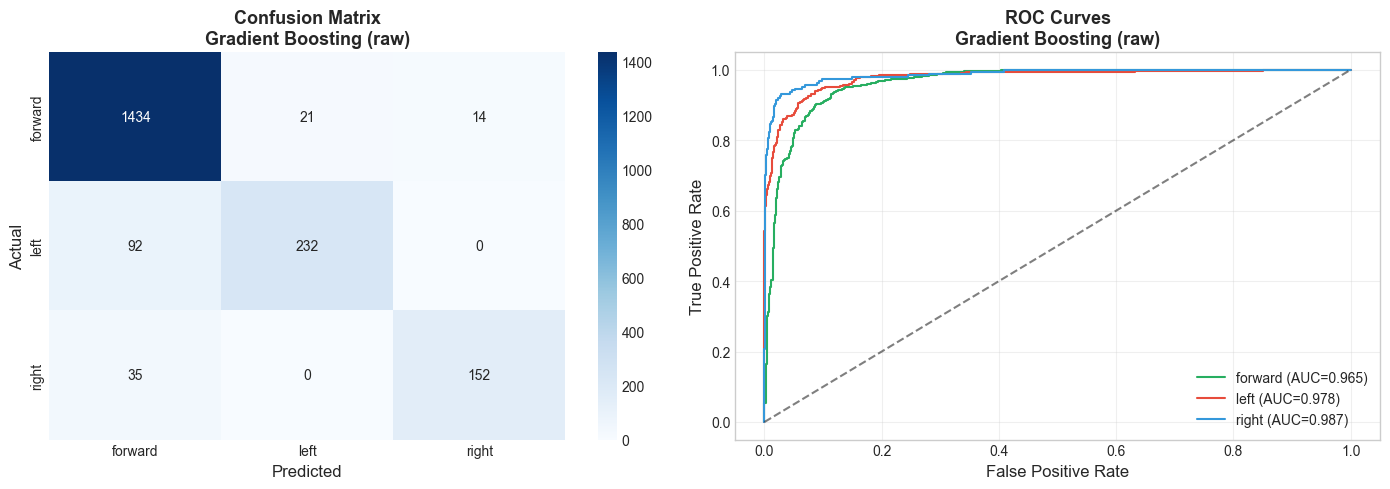

In [5]:
# Gradient Boosting on RAW features
print("Training Gradient Boosting on RAW (PCA) features...")

gb_raw = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=RANDOM_STATE
)

gb_raw.fit(raw_processed['X_train'], raw_processed['y_train'])

results_gb_raw = evaluate_model(
    gb_raw,
    raw_processed['X_test'],
    raw_processed['y_test'],
    model_name='Gradient Boosting',
    feature_type='raw',
    label_encoder=raw_processed['label_encoder']
)


Training Gradient Boosting on ENGINEERED features...

Model: Gradient Boosting | Features: engineered
Accuracy:          0.8960
Balanced Accuracy: 0.7914
Macro F1:          0.8261
Weighted F1:       0.8922
Macro Precision:   0.8735
Macro Recall:      0.7914
ROC-AUC (macro):   0.9653

Per-class metrics:
  forward   : F1=0.9325, Precision=0.9031, Recall=0.9639
  left      : F1=0.7852, Precision=0.9139, Recall=0.6883
  right     : F1=0.7606, Precision=0.8036, Recall=0.7219

Classification Report:
              precision    recall  f1-score   support

     forward       0.90      0.96      0.93      1469
        left       0.91      0.69      0.79       324
       right       0.80      0.72      0.76       187

    accuracy                           0.90      1980
   macro avg       0.87      0.79      0.83      1980
weighted avg       0.90      0.90      0.89      1980



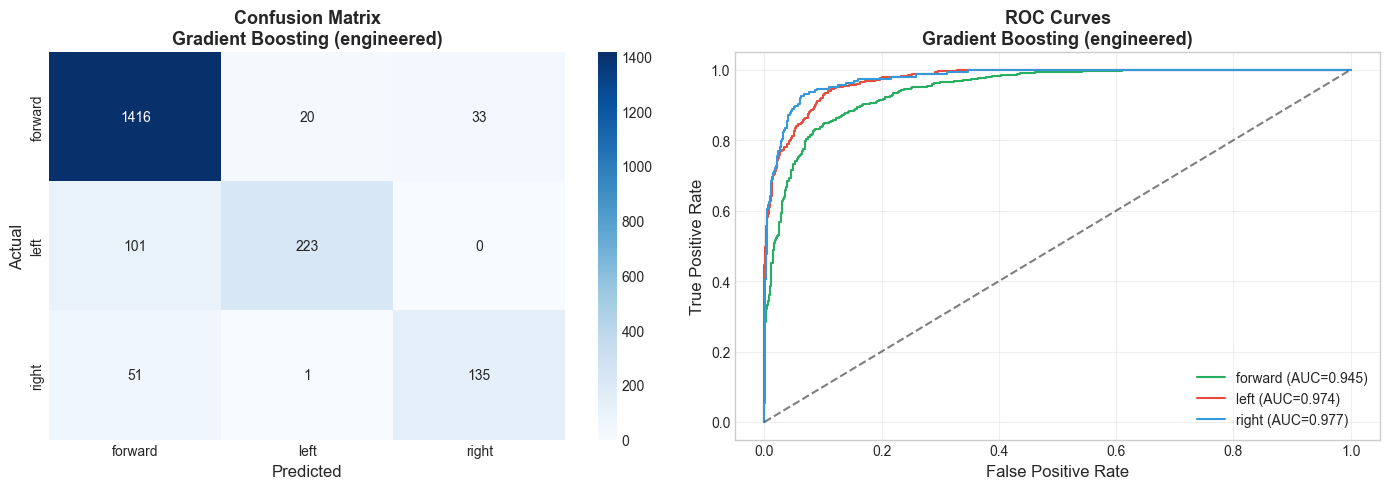

In [6]:
# Gradient Boosting on ENGINEERED features
print("Training Gradient Boosting on ENGINEERED features...")

gb_eng = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=RANDOM_STATE
)

gb_eng.fit(eng_processed['X_train'], eng_processed['y_train'])

results_gb_eng = evaluate_model(
    gb_eng,
    eng_processed['X_test'],
    eng_processed['y_test'],
    model_name='Gradient Boosting',
    feature_type='engineered',
    label_encoder=eng_processed['label_encoder']
)


## 4. Results Summary


In [7]:
# Summary
all_results = [results_ada_raw, results_ada_eng, results_gb_raw, results_gb_eng]

summary_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Features': r['feature_type'],
        'Accuracy': r['accuracy'],
        'Balanced Acc': r['balanced_accuracy'],
        'F1 (Macro)': r['f1_macro'],
        'ROC-AUC': r['roc_auc']
    }
    for r in all_results
])

print("\n" + "="*80)
print("BOOSTING RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))



BOOSTING RESULTS SUMMARY
            Model   Features  Accuracy  Balanced Acc  F1 (Macro)  ROC-AUC
         AdaBoost        raw  0.825758      0.707870    0.731250 0.851950
         AdaBoost engineered  0.601515      0.721036    0.562007 0.848059
Gradient Boosting        raw  0.918182      0.835019    0.870628 0.976320
Gradient Boosting engineered  0.895960      0.791373    0.826091 0.965293


In [8]:
# Save results
save_results(all_results, 'boosting')
print("Results saved successfully!")


Results saved to ../../data/model_results/boosting_results.json
Results saved successfully!


## 5. Key Observations

### AdaBoost
- Uses exponential loss function
- Weights samples by prediction error
- Sensitive to outliers (exponential loss)
- Uses decision stumps (max_depth=1) as weak learners

### Gradient Boosting
- More flexible (any differentiable loss function)
- Fits trees to pseudo-residuals
- Shrinkage (learning_rate < 1) reduces overfitting
- Subsampling adds stochasticity (like bagging)

### Comparison
- Gradient Boosting typically more robust than AdaBoost
- AdaBoost simpler to understand and implement
- Both reduce bias while controlling variance
